In [114]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [207]:
!pip install xgboost

  Using cached xgboost-1.5.0-py3-none-win_amd64.whl (106.6 MB)


In [115]:
app_df = pd.read_csv('application_record.csv')
credit_df = pd.read_csv('credit_record.csv')

In [116]:
app_df.shape

(438557, 18)

In [117]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [118]:
credit_df.shape

(1048575, 3)

In [119]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


# Exploratory Data Analysis (EDA)

In [120]:
app_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [121]:
app_df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [122]:
# dropping occupation type which has many null values
app_df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [123]:
# Checking duplicates in 'ID' column
len(app_df['ID']) - len(app_df['ID'].unique())

47

In [124]:
# Dropping duplicate entries from ID column
app_df = app_df.drop_duplicates('ID', keep='last') 

In [125]:
# Checking Non-Numerical Columns
cat_columns = app_df.columns[(app_df.dtypes =='object').values].tolist()
cat_columns

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [126]:
# Checking Numerical Columns
app_df.columns[(app_df.dtypes !='object').values].tolist()

['ID',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS']

In [127]:
# Checking unique values from Categorical Columns

for i in app_df.columns[(app_df.dtypes =='object').values].tolist():
    print(i,'\n')
    print(app_df[i].value_counts())
    print('-----------------------------------------------')

CODE_GENDER 

F    294412
M    144098
Name: CODE_GENDER, dtype: int64
-----------------------------------------------
FLAG_OWN_CAR 

N    275428
Y    163082
Name: FLAG_OWN_CAR, dtype: int64
-----------------------------------------------
FLAG_OWN_REALTY 

Y    304043
N    134467
Name: FLAG_OWN_REALTY, dtype: int64
-----------------------------------------------
NAME_INCOME_TYPE 

Working                 226087
Commercial associate    100739
Pensioner                75483
State servant            36184
Student                     17
Name: NAME_INCOME_TYPE, dtype: int64
-----------------------------------------------
NAME_EDUCATION_TYPE 

Secondary / secondary special    301789
Higher education                 117509
Incomplete higher                 14849
Lower secondary                    4051
Academic degree                     312
Name: NAME_EDUCATION_TYPE, dtype: int64
-----------------------------------------------
NAME_FAMILY_STATUS 

Married                 299798
Single / not ma

In [128]:
app_df['CNT_CHILDREN'].value_counts()

0     304038
1      88518
2      39879
3       5430
4        486
5        133
7          9
9          5
12         4
6          4
14         3
19         1
Name: CNT_CHILDREN, dtype: int64

In [129]:
# Checking Min , Max values from 'DAYS_BIRTH' column
print('Min DAYS_BIRTH :', app_df['DAYS_BIRTH'].min(),'\nMax DAYS_BIRTH :', app_df['DAYS_BIRTH'].max())

Min DAYS_BIRTH : -25201 
Max DAYS_BIRTH : -7489


In [130]:
# Converting 'DAYS_BIRTH' values from Day to Years
app_df['DAYS_BIRTH'] = round(app_df['DAYS_BIRTH']/-365,0)
app_df.rename(columns={'DAYS_BIRTH':'AGE_YEARS'}, inplace=True)

In [131]:
# Checking unique values greater than 0
app_df[app_df['DAYS_EMPLOYED']>0]['DAYS_EMPLOYED'].unique()

array([365243], dtype=int64)

In [132]:
# As mentioned in document, if 'DAYS_EMPLOYED' is positive no, it means person currently unemployed, hence replacing it with 0
app_df['DAYS_EMPLOYED'].replace(365243, 0, inplace=True)

In [133]:
# Converting 'DAYS_EMPLOYED' values from Day to Years
app_df['DAYS_EMPLOYED'] = abs(round(app_df['DAYS_EMPLOYED']/-365,0))
app_df.rename(columns={'DAYS_EMPLOYED':'YEARS_EMPLOYED'}, inplace=True)   

In [134]:
# As all the values in column are 1, hence dropping column
app_df.drop('FLAG_MOBIL', axis=1, inplace=True)

In [135]:
# This column only contains 0 & 1 values for Mobile no submitted, hence dropping column
app_df.drop('FLAG_WORK_PHONE', axis=1, inplace=True)

In [136]:
# This column only contains 0 & 1 values for Phone no submitted, hence dropping column
app_df.drop('FLAG_PHONE', axis=1, inplace=True)

In [137]:
app_df['FLAG_EMAIL'].value_counts()

0    391062
1     47448
Name: FLAG_EMAIL, dtype: int64

In [138]:
# This column only contains 0 & 1 values for Email submitted, hence dropping column
app_df.drop('FLAG_EMAIL', axis=1, inplace=True)

In [139]:
app_df['CNT_FAM_MEMBERS'].value_counts()

2.0     233867
1.0      84483
3.0      77119
4.0      37351
5.0       5081
6.0        459
7.0        124
9.0          9
11.0         5
8.0          4
14.0         4
15.0         3
20.0         1
Name: CNT_FAM_MEMBERS, dtype: int64

In [140]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,12.0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33.0,12.0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,3.0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,8.0,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,52.0,8.0,1.0


# Visualization

<AxesSubplot:xlabel='CNT_CHILDREN'>

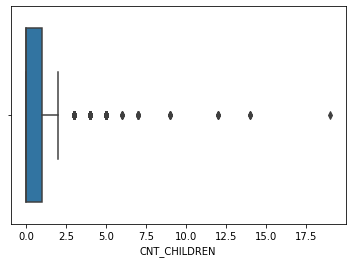

In [141]:
#create plot to detect outliers
sns.boxplot(app_df['CNT_CHILDREN'])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL'>

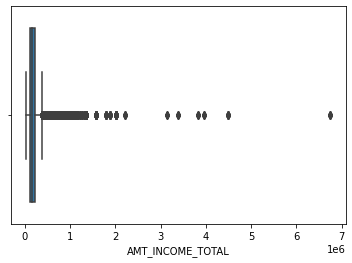

In [142]:
sns.boxplot(app_df['AMT_INCOME_TOTAL'])

<AxesSubplot:xlabel='AGE_YEARS'>

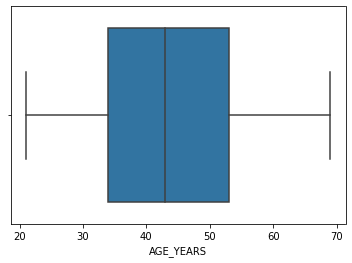

In [143]:
sns.boxplot(app_df['AGE_YEARS'])

<AxesSubplot:xlabel='YEARS_EMPLOYED'>

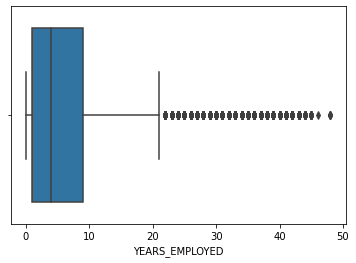

In [144]:
sns.boxplot(app_df['YEARS_EMPLOYED'])

<AxesSubplot:xlabel='CNT_FAM_MEMBERS'>

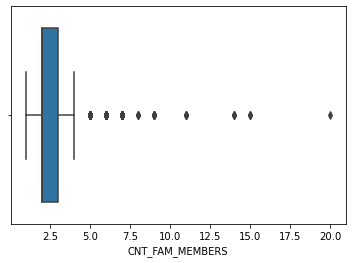

In [145]:
sns.boxplot(app_df['CNT_FAM_MEMBERS'])

## Removing Outlier

In [146]:
high_bound = app_df['CNT_CHILDREN'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = app_df['CNT_CHILDREN'].quantile(0.001)
print('low_bound :', low_bound)

high_bound : 4.0
low_bound : 0.0


In [147]:
app_df = app_df[(app_df['CNT_CHILDREN']>=low_bound) & (app_df['CNT_CHILDREN']<=high_bound)]

In [148]:
high_bound = app_df['AMT_INCOME_TOTAL'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = app_df['AMT_INCOME_TOTAL'].quantile(0.001)
print('low_bound :', low_bound)
high_bound : 990000.0

high_bound : 990000.0
low_bound : 36000.0


In [149]:
app_df = app_df[(app_df['AMT_INCOME_TOTAL']>=low_bound) & (app_df['AMT_INCOME_TOTAL']<=high_bound)]

In [150]:
high_bound = app_df['YEARS_EMPLOYED'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = app_df['YEARS_EMPLOYED'].quantile(0.001)
print('low_bound :', low_bound)

high_bound : 40.0
low_bound : 0.0


In [151]:
app_df = app_df[(app_df['YEARS_EMPLOYED']>=low_bound) & (app_df['YEARS_EMPLOYED']<=high_bound)]

In [152]:
high_bound = app_df['CNT_FAM_MEMBERS'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = app_df['CNT_FAM_MEMBERS'].quantile(0.001)
print('low_bound :', low_bound)

high_bound : 6.0
low_bound : 1.0


In [153]:
app_df = app_df[(app_df['YEARS_EMPLOYED']>=low_bound) & (app_df['YEARS_EMPLOYED']<=high_bound)]

In [154]:
high_bound = app_df['CNT_FAM_MEMBERS'].quantile(0.999)
print('high_bound :', high_bound)
low_bound = app_df['CNT_FAM_MEMBERS'].quantile(0.001)
print('low_bound :', low_bound)

high_bound : 6.0
low_bound : 1.0


In [155]:
app_df = app_df[(app_df['CNT_FAM_MEMBERS']>=low_bound) & (app_df['CNT_FAM_MEMBERS']<=high_bound)]

In [156]:
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,3.0,2.0
10,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0
11,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0
12,6153651,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0
13,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,49.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
438541,6837707,M,N,Y,0,202500.0,Working,Higher education,Civil marriage,House / apartment,37.0,6.0,2.0
438544,6838056,F,N,Y,0,135000.0,State servant,Secondary / secondary special,Married,House / apartment,52.0,1.0,2.0
438548,6839936,M,Y,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,34.0,6.0,3.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,22.0,1.0,1.0


In [157]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [158]:
credit_df.head().T

,0,1,2,3,4
ID,5001711,5001711,5001711,5001711,5001712
MONTHS_BALANCE,0,-1,-2,-3,0
STATUS,X,0,0,0,C


In [159]:
app_df.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
AGE_YEARS              0
YEARS_EMPLOYED         0
CNT_FAM_MEMBERS        0
dtype: int64

In [160]:
credit_df['STATUS'].value_counts()

C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: STATUS, dtype: int64

In [162]:
# categorizing 'STATUS' column to binary classification   0 : Good Client and 1 : bad client
credit_df['STATUS'].replace(['C', 'X'],0, inplace=True)
credit_df['STATUS'].replace(['2','3','4','5'],1, inplace=True)

In [163]:
credit_df['STATUS'] = credit_df['STATUS'].astype('int')

In [164]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype
---  ------          --------------    -----
 0   ID              1048575 non-null  int64
 1   MONTHS_BALANCE  1048575 non-null  int64
 2   STATUS          1048575 non-null  int32
dtypes: int32(1), int64(2)
memory usage: 20.0 MB


In [165]:
credit_df['STATUS'].value_counts(normalize=True)*100

0    98.646353
1     1.353647
Name: STATUS, dtype: float64

In [166]:
credit_df_trans = credit_df.groupby('ID').agg(max).reset_index()
credit_df_trans.drop('MONTHS_BALANCE', axis=1, inplace=True)
credit_df_trans.head()

,ID,STATUS
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [167]:
credit_df_trans['STATUS'].value_counts(normalize=True)*100

0    88.365771
1    11.634229
Name: STATUS, dtype: float64

## Merging Dataframes

In [168]:
# merging the two datasets based on 'ID'
final_df = pd.merge(app_df, credit_df_trans, on='ID', how='inner')
final_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,3.0,2.0,0
1,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0,0
2,5112956,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0,0
3,5008819,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,49.0,3.0,2.0,0
4,5008820,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,49.0,3.0,2.0,0


In [169]:
final_df.shape

(16386, 14)

In [170]:
# dropping 'ID' column as it is having only unique values (not required for ML Model)
final_df.drop('ID', axis=1, inplace=True)

In [171]:
# checking if there are still duplicate rows in Final Dataframe
len(final_df) - len(final_df.drop_duplicates())

11087

In [172]:
# Dropping duplicate records
final_df = final_df.drop_duplicates()
final_df.reset_index(drop=True ,inplace=True)

In [173]:
final_df.shape

(5299, 13)

In [174]:
final_df.isnull().sum()

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
AGE_YEARS              0
YEARS_EMPLOYED         0
CNT_FAM_MEMBERS        0
STATUS                 0
dtype: int64

In [175]:
final_df['STATUS'].value_counts(normalize=True)*100

0    77.976977
1    22.023023
Name: STATUS, dtype: float64

## Visualization¶

In [176]:
final_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,3.0,2.0,0
1,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0,0
2,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,49.0,3.0,2.0,0
3,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29.0,3.0,2.0,1
4,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,27.0,4.0,2.0,1


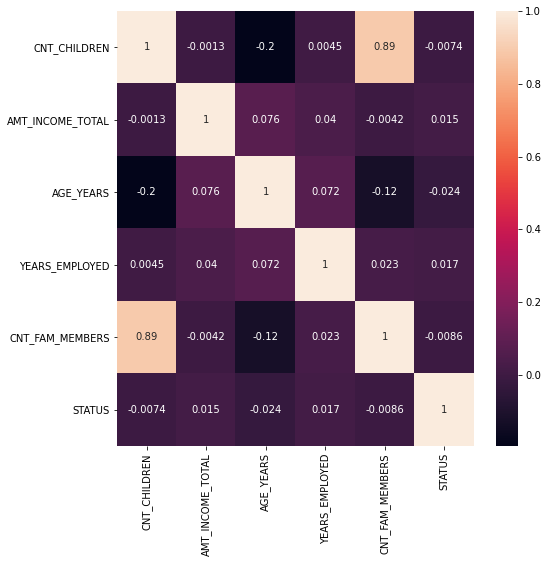

In [177]:
# This graph shows that, there is no column (Feature) which is highly co-related with 'Status'
plt.figure(figsize = (8,8))
sns.heatmap(final_df.corr(), annot=True)
plt.show()

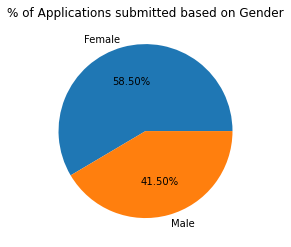

In [178]:
# This graph shows that, majority of application are submitted by Female's
plt.pie(final_df['CODE_GENDER'].value_counts(), labels=['Female', 'Male'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on Gender')
plt.show()

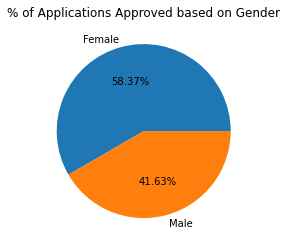

In [179]:
# This graph shows that, majority of application are approved for Female's
plt.pie(final_df[final_df['STATUS']==0]['CODE_GENDER'].value_counts(), labels=['Female', 'Male'], autopct='%1.2f%%')
plt.title('% of Applications Approved based on Gender')
plt.show()


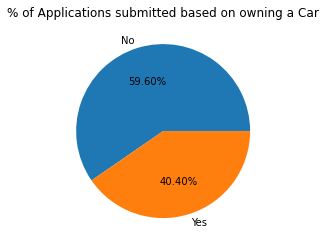

In [180]:
# This graph shows that, majority of applicatant's dont own a car
plt.pie(final_df['FLAG_OWN_CAR'].value_counts(), labels=['No', 'Yes'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on owning a Car')
plt.show()

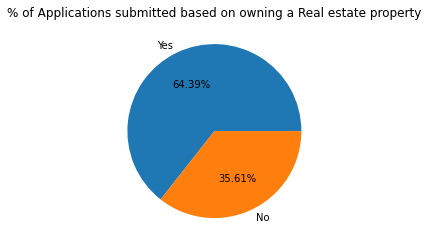

In [182]:
#This graph shows that, majority of applicatant's own a Real Estate property / House
plt.pie(final_df['FLAG_OWN_REALTY'].value_counts(), labels=['Yes','No'], autopct='%1.2f%%')
plt.title('% of Applications submitted based on owning a Real estate property')
plt.show()


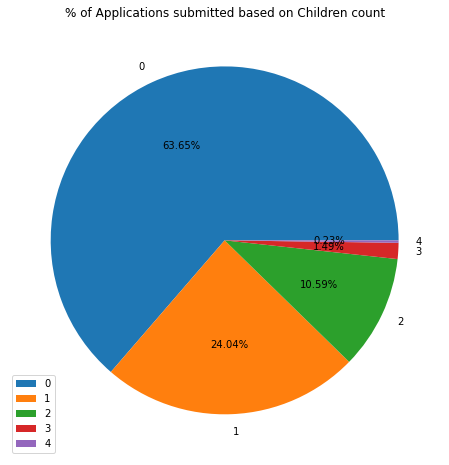

In [183]:
# This graph shows that, majority of applicatant's don't have any children
plt.figure(figsize = (8,8))
plt.pie(final_df['CNT_CHILDREN'].value_counts(), labels=final_df['CNT_CHILDREN'].value_counts().index, autopct='%1.2f%%')
plt.title('% of Applications submitted based on Children count')
plt.legend()
plt.show()

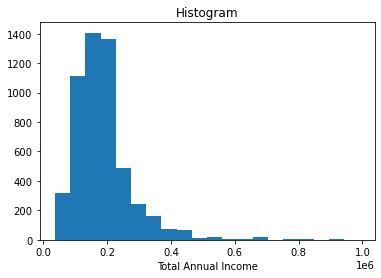

In [184]:
# This graph shows that, majority of applicatant's income lies between 1 to 3 lakh
plt.hist(final_df['AMT_INCOME_TOTAL'], bins=20)
plt.xlabel('Total Annual Income')
plt.title('Histogram')
plt.show()

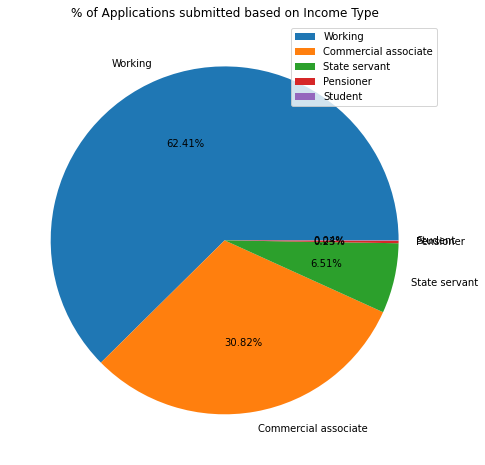

In [185]:
# This graph shows that, majority of applicatant's are working professional
plt.figure(figsize = (8,8))
plt.pie(final_df['NAME_INCOME_TYPE'].value_counts(), labels=final_df['NAME_INCOME_TYPE'].value_counts().index, autopct='%1.2f%%')
plt.title('% of Applications submitted based on Income Type')
plt.legend()
plt.show()

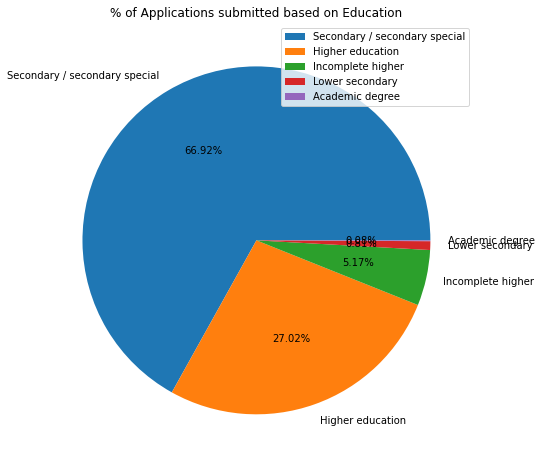

In [186]:
# This graph shows that, majority of applicatant's completed the Secondary Education
plt.figure(figsize=(8,8))
plt.pie(final_df['NAME_EDUCATION_TYPE'].value_counts(), labels=final_df['NAME_EDUCATION_TYPE'].value_counts().index, autopct='%1.2f%%')
plt.title('% of Applications submitted based on Education')
plt.legend()
plt.show()


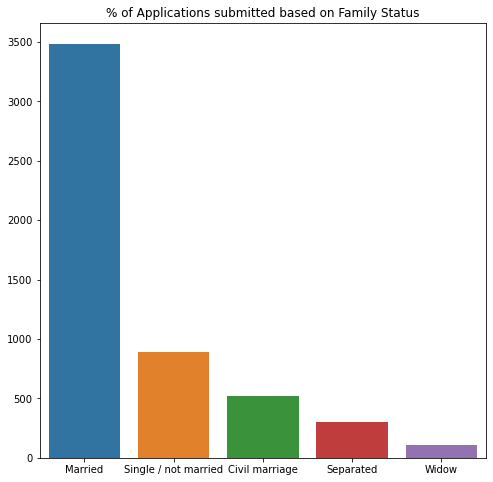

In [187]:
# This graph shows that, majority of applicatant's are married
plt.figure(figsize=(8,8))
sns.barplot(final_df['NAME_FAMILY_STATUS'].value_counts().index, final_df['NAME_FAMILY_STATUS'].value_counts().values)
plt.title('% of Applications submitted based on Family Status')
plt.show()

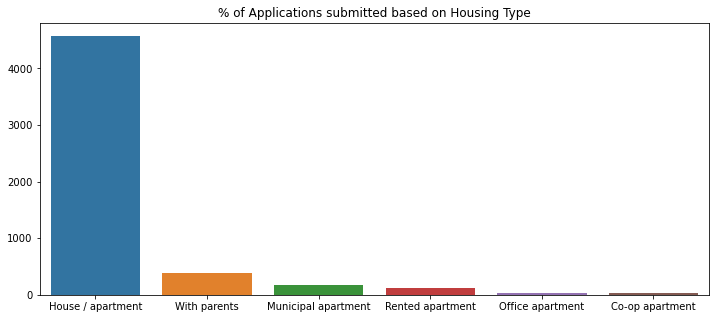

In [188]:
# This graph shows that, majority of applicatant's lives in House / Apartment
plt.figure(figsize=(12,5))
sns.barplot(final_df['NAME_HOUSING_TYPE'].value_counts().index, final_df['NAME_HOUSING_TYPE'].value_counts().values)
plt.title('% of Applications submitted based on Housing Type')
plt.show()


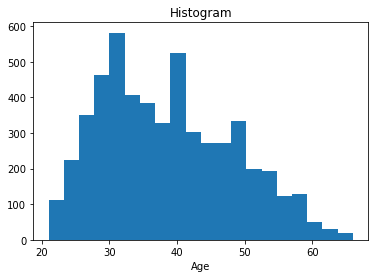

In [189]:
# This graph shows that, majority of applicatant's are 25 to 65 years old
plt.hist(final_df['AGE_YEARS'], bins=20)
plt.xlabel('Age')
plt.title('Histogram')
plt.show()

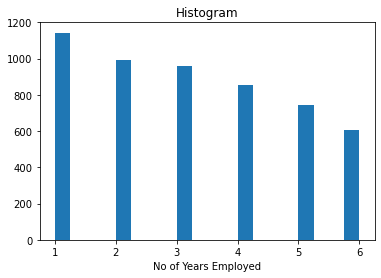

In [190]:
# This graph shows that, majority of applicatant's are Employed for 0 to 7 years
plt.hist(final_df['YEARS_EMPLOYED'], bins=20)
plt.xlabel('No of Years Employed')
plt.title('Histogram')
plt.show()

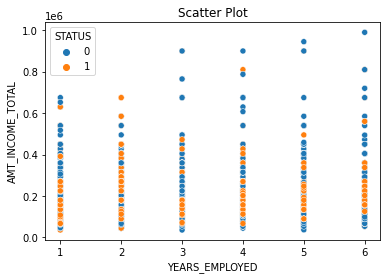

In [191]:
# This graph shows that, majority of applications are rejected if Total income & years of Employment is less
sns.scatterplot(final_df['YEARS_EMPLOYED'], final_df['AMT_INCOME_TOTAL'], hue=final_df['STATUS'])
plt.title('Scatter Plot')
plt.show()

## Feature Selection

In [192]:
final_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59.0,3.0,2.0,0
1,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,46.0,2.0,2.0,0
2,M,Y,Y,0,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,49.0,3.0,2.0,0
3,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,29.0,3.0,2.0,1
4,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,27.0,4.0,2.0,1


In [193]:
cat_columns = final_df.columns[(final_df.dtypes =='object').values].tolist()
cat_columns

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE']

In [194]:
#Converting all Non-Numerical Columns to Numerical
from sklearn.preprocessing import LabelEncoder

for col in cat_columns:
        globals()['LE_{}'.format(col)] = LabelEncoder()
        final_df[col] = globals()['LE_{}'.format(col)].fit_transform(final_df[col])
final_df.head()    

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
0,1,1,1,0,112500.0,4,4,1,1,59.0,3.0,2.0,0
1,1,1,1,0,270000.0,4,1,1,1,46.0,2.0,2.0,0
2,1,1,1,0,135000.0,0,4,1,1,49.0,3.0,2.0,0
3,0,1,0,0,130500.0,4,2,1,1,29.0,3.0,2.0,1
4,0,0,1,0,157500.0,4,4,1,1,27.0,4.0,2.0,1


In [195]:
for col in cat_columns:
    print(col , "  : ", globals()['LE_{}'.format(col)].classes_)

CODE_GENDER   :  ['F' 'M']
FLAG_OWN_CAR   :  ['N' 'Y']
FLAG_OWN_REALTY   :  ['N' 'Y']
NAME_INCOME_TYPE   :  ['Commercial associate' 'Pensioner' 'State servant' 'Student' 'Working']
NAME_EDUCATION_TYPE   :  ['Academic degree' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Secondary / secondary special']
NAME_FAMILY_STATUS   :  ['Civil marriage' 'Married' 'Separated' 'Single / not married' 'Widow']
NAME_HOUSING_TYPE   :  ['Co-op apartment' 'House / apartment' 'Municipal apartment'
 'Office apartment' 'Rented apartment' 'With parents']


In [196]:
final_df.corr()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS,STATUS
CODE_GENDER,1.000000,0.321981,-0.042332,-0.006332,0.188472,0.042950,0.045542,-0.006617,0.040145,-0.058595,-0.034719,0.004678,-0.004886
FLAG_OWN_CAR,0.321981,1.000000,0.016401,0.047927,0.206872,0.000067,-0.080480,-0.100440,-0.028770,-0.022013,0.015396,0.093155,-0.002332
FLAG_OWN_REALTY,-0.042332,0.016401,1.000000,0.030429,0.026523,-0.028556,0.007636,-0.022624,-0.194530,0.134116,-0.004188,0.037235,-0.023229
CNT_CHILDREN,-0.006332,0.047927,0.030429,1.000000,-0.001316,0.005865,0.000304,-0.183537,-0.021902,-0.196747,0.004514,0.894409,-0.007448
AMT_INCOME_TOTAL,0.188472,0.206872,0.026523,-0.001316,1.000000,-0.141800,-0.228342,0.004051,-0.031349,0.075510,0.040002,-0.004239,0.014609
NAME_INCOME_TYPE,0.042950,0.000067,-0.028556,0.005865,-0.141800,1.000000,0.142649,0.017786,0.001487,0.009637,0.004689,-0.000760,-0.018984
NAME_EDUCATION_TYPE,0.045542,-0.080480,0.007636,0.000304,-0.228342,0.142649,1.000000,-0.018086,-0.040838,0.152445,-0.003590,0.003437,-0.006854
NAME_FAMILY_STATUS,-0.006617,-0.100440,-0.022624,-0.183537,0.004051,0.017786,-0.018086,1.000000,0.064070,-0.046616,-0.027473,-0.552480,0.009529
NAME_HOUSING_TYPE,0.040145,-0.028770,-0.194530,-0.021902,-0.031349,0.001487,-0.040838,0.064070,1.000000,-0.207861,-0.037779,-0.059396,0.016952
AGE_YEARS,-0.058595,-0.022013,0.134116,-0.196747,0.075510,0.009637,0.152445,-0.046616,-0.207861,1.000000,0.072122,-0.122909,-0.024361


In [197]:
features = final_df.drop(['STATUS'], axis=1)
label = final_df['STATUS']

In [198]:
features.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,AGE_YEARS,YEARS_EMPLOYED,CNT_FAM_MEMBERS
0,1,1,1,0,112500.0,4,4,1,1,59.0,3.0,2.0
1,1,1,1,0,270000.0,4,1,1,1,46.0,2.0,2.0
2,1,1,1,0,135000.0,0,4,1,1,49.0,3.0,2.0
3,0,1,0,0,130500.0,4,2,1,1,29.0,3.0,2.0
4,0,0,1,0,157500.0,4,4,1,1,27.0,4.0,2.0


In [199]:
label.head()

0    0
1    0
2    0
3    1
4    1
Name: STATUS, dtype: int32

### Machine Learning Model

In [200]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,
                                                    label,
                                                    test_size=0.2,
                                                    random_state = 10)

## Logistic Regression

In [201]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

log_model = LogisticRegression()
log_model.fit(x_train, y_train)

print('Logistic Model Accuracy : ', log_model.score(x_test, y_test)*100, '%')

prediction = log_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Logistic Model Accuracy :  77.73584905660378 %

Confusion matrix :
[[824   0]
 [236   0]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       824
           1       0.00      0.00      0.00       236

    accuracy                           0.78      1060
   macro avg       0.39      0.50      0.44      1060
weighted avg       0.60      0.78      0.68      1060



In [202]:
# Decision Tree classification

from sklearn.tree import DecisionTreeClassifier

decision_model = DecisionTreeClassifier(max_depth=12,min_samples_split=8)

decision_model.fit(x_train, y_train)

print('Decision Tree Model Accuracy : ', decision_model.score(x_test, y_test)*100, '%')

prediction = decision_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Decision Tree Model Accuracy :  68.30188679245282 %

Confusion matrix :
[[712 112]
 [224  12]]

Classification report:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81       824
           1       0.10      0.05      0.07       236

    accuracy                           0.68      1060
   macro avg       0.43      0.46      0.44      1060
weighted avg       0.61      0.68      0.64      1060



## Random Forest classification

In [203]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_model = RandomForestClassifier(n_estimators=250,
                                            max_depth=12,
                                            min_samples_leaf=16)

RandomForest_model.fit(x_train, y_train)

print('Random Forest Model Accuracy : ', RandomForest_model.score(x_test, y_test)*100, '%')

prediction = RandomForest_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Random Forest Model Accuracy :  77.73584905660378 %

Confusion matrix :
[[824   0]
 [236   0]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       824
           1       0.00      0.00      0.00       236

    accuracy                           0.78      1060
   macro avg       0.39      0.50      0.44      1060
weighted avg       0.60      0.78      0.68      1060



## Support Vector Machine classification

In [204]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(x_train, y_train)

print('Support Vector Classifier Accuracy : ', svc_model.score(x_test, y_test)*100, '%')

prediction = svc_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

Support Vector Classifier Accuracy :  77.73584905660378 %

Confusion matrix :
[[824   0]
 [236   0]]

Classification report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87       824
           1       0.00      0.00      0.00       236

    accuracy                           0.78      1060
   macro avg       0.39      0.50      0.44      1060
weighted avg       0.60      0.78      0.68      1060



## K Nearest Neighbor classification

In [209]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 7)

knn_model.fit(x_train, y_train)

print('KNN Model Accuracy : ', knn_model.score(x_test, y_test)*100, '%')

prediction = knn_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

KNN Model Accuracy :  74.62264150943396 %

Confusion matrix :
[[786  38]
 [231   5]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.95      0.85       824
           1       0.12      0.02      0.04       236

    accuracy                           0.75      1060
   macro avg       0.44      0.49      0.44      1060
weighted avg       0.63      0.75      0.67      1060



## XGBoost  classification

In [210]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier()

XGB_model.fit(x_train, y_train)

print('XGBoost Model Accuracy : ', XGB_model.score(x_test, y_test)*100, '%')

prediction = XGB_model.predict(x_test)
print('\nConfusion matrix :')
print(confusion_matrix(y_test, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test, prediction))

[21:36:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Model Accuracy :  70.66037735849056 %

Confusion matrix :
[[737  87]
 [224  12]]

Classification report:
              precision    recall  f1-score   support

           0       0.77      0.89      0.83       824
           1       0.12      0.05      0.07       236

    accuracy                           0.71      1060
   macro avg       0.44      0.47      0.45      1060
weighted avg       0.62      0.71      0.66      1060



## Balancing dataset

In [211]:
# scaling all features
from sklearn.preprocessing import MinMaxScaler
MMS = MinMaxScaler()
x_train_scaled = pd.DataFrame(MMS.fit_transform(x_train), columns=x_train.columns)
x_test_scaled = pd.DataFrame(MMS.transform(x_test), columns=x_test.columns)

In [213]:
#adding samples to minority class using SMOTE
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

x_train_oversam, y_train_oversam = oversample.fit_resample(x_train_scaled, y_train)
x_test_oversam, y_test_oversam = oversample.fit_resample(x_test_scaled, y_test)

In [214]:
# Original majority and minority class
y_train.value_counts(normalize=True)*100

0    78.037273
1    21.962727
Name: STATUS, dtype: float64

In [215]:
# after using SMOTE 
y_train_oversam.value_counts(normalize=True)*100

1    50.0
0    50.0
Name: STATUS, dtype: float64

## Model after Balancing

## Logistic Regression

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

log_model = LogisticRegression()
log_model.fit(x_train_oversam, y_train_oversam)

print('Logistic Model Accuracy : ', log_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = log_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

Logistic Model Accuracy :  48.786407766990294 %

Confusion matrix :
[[434 390]
 [454 370]]

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       824
           1       0.49      0.45      0.47       824

    accuracy                           0.49      1648
   macro avg       0.49      0.49      0.49      1648
weighted avg       0.49      0.49      0.49      1648



## Decision Tree classification

In [217]:
from sklearn.tree import DecisionTreeClassifier

decision_model = DecisionTreeClassifier(max_depth=12,min_samples_split=8)

decision_model.fit(x_train_oversam, y_train_oversam)

print('Decision Tree Model Accuracy : ', decision_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = decision_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

Decision Tree Model Accuracy :  72.69417475728154 %

Confusion matrix :
[[690 134]
 [316 508]]

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.84      0.75       824
           1       0.79      0.62      0.69       824

    accuracy                           0.73      1648
   macro avg       0.74      0.73      0.72      1648
weighted avg       0.74      0.73      0.72      1648



## Random Forest classification

In [218]:
from sklearn.ensemble import RandomForestClassifier

RandomForest_model = RandomForestClassifier(n_estimators=250,
                                            max_depth=12,
                                            min_samples_leaf=16)

RandomForest_model.fit(x_train_oversam, y_train_oversam)

print('Random Forest Model Accuracy : ', RandomForest_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = RandomForest_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

Random Forest Model Accuracy :  75.72815533980582 %

Confusion matrix :
[[723 101]
 [299 525]]

Classification report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.78       824
           1       0.84      0.64      0.72       824

    accuracy                           0.76      1648
   macro avg       0.77      0.76      0.75      1648
weighted avg       0.77      0.76      0.75      1648



## Support Vector Machine classification

In [219]:
from sklearn.svm import SVC

svc_model = SVC()

svc_model.fit(x_train_oversam, y_train_oversam)

print('Support Vector Classifier Accuracy : ', svc_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = svc_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

Support Vector Classifier Accuracy :  49.029126213592235 %

Confusion matrix :
[[392 432]
 [408 416]]

Classification report:
              precision    recall  f1-score   support

           0       0.49      0.48      0.48       824
           1       0.49      0.50      0.50       824

    accuracy                           0.49      1648
   macro avg       0.49      0.49      0.49      1648
weighted avg       0.49      0.49      0.49      1648



## K Nearest Neighbor classification

In [220]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 7)

knn_model.fit(x_train_oversam, y_train_oversam)

print('KNN Model Accuracy : ', knn_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = knn_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

KNN Model Accuracy :  44.538834951456316 %

Confusion matrix :
[[414 410]
 [504 320]]

Classification report:
              precision    recall  f1-score   support

           0       0.45      0.50      0.48       824
           1       0.44      0.39      0.41       824

    accuracy                           0.45      1648
   macro avg       0.44      0.45      0.44      1648
weighted avg       0.44      0.45      0.44      1648



## XGBoost  classification

In [221]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier()

XGB_model.fit(x_train_oversam, y_train_oversam)

print('XGBoost Model Accuracy : ', XGB_model.score(x_test_oversam, y_test_oversam)*100, '%')

prediction = XGB_model.predict(x_test_oversam)
print('\nConfusion matrix :')
print(confusion_matrix(y_test_oversam, prediction))
      
print('\nClassification report:')      
print(classification_report(y_test_oversam, prediction))

[21:50:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Model Accuracy :  79.49029126213593 %

Confusion matrix :
[[723 101]
 [237 587]]

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       824
           1       0.85      0.71      0.78       824

    accuracy                           0.79      1648
   macro avg       0.80      0.79      0.79      1648
weighted avg       0.80      0.79      0.79      1648

